# Surface age prediction using saved models



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import sklearn
import joblib
import os
import math
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
from sklearn.linear_model import HuberRegressor
from scipy.stats import t

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from keras.layers import Dense, Conv1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor,GradientBoostingRegressor,RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.neighbors import KNeighborsRegressor
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import r2_score
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split

In [ ]:
#CNN model
def create_cnn_model_1(input_shape,learning_rate=0.001):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation="relu", padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=2, activation="relu", padding="same"))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(1, activation="relu"))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=["mean_absolute_error"])
    return model

This class extends KerasRegressor to integrate a CNN model for predicting continuous outputs.

In [ ]:
#Custom Keras Regressor class for CNN-based regression tasks.

class CNNRegressor(KerasRegressor):
    _estimator_type = "regressor"

    def __init__(self, input_shape, learning_rate=0.001, epochs=10, batch_size=32, verbose=0, **kwargs):
        super().__init__(**kwargs)
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        #super().__init__(build_fn=self._keras_build_fn, **kwargs)

    def _keras_build_fn(self):
        return create_cnn_model_1(self.input_shape, self.learning_rate)

In [ ]:
# Define choices for H ion irradiation (H) and lasser irradiation (L)
choices = {'H': 3, 'L': 12}

# Load the input data sheet
input_file = file_path + "asteroid_reflectance_spectra.xlsx"  # Replace with your file name
input_data = pd.read_excel(input_file)

# Retain the first two columns as identifiers
identifiers = input_data.iloc[:, :2]  # First two columns

# Separate features (X) and target (y), excluding the first two columns
X = input_data.iloc[:, 2:-1].to_numpy()  # Columns 3 to second-last as features
y = input_data.iloc[:, -1].copy()       # The last column (target)

# Initialize a DataFrame to store predictions for both H and L
all_predictions_combined = identifiers.copy()  # Start with identifiers

# Folder containing the saved models
models_folder = "Models"

for choice, adjustment_value in choices.items():
    # Adjust the target values based on the current choice
    y_adjusted = y + adjustment_value

    # Reconstruct the modified dataset for predictions
    X_modified = np.hstack([X, y_adjusted.values.reshape(-1, 1)])

    # Initialize a DataFrame to store predictions for this choice
    predictions = []
    for iteration in range(1, 31):
        model_filename = os.path.join(models_folder, f"ensemble_model_{iteration}.joblib")
        print(f"Loading model: {model_filename} for choice {choice}")
        ensemble_model = joblib.load(model_filename)

        # Ensure input data is in the correct format
        X_modified = X_modified.astype(np.float32)

        # Predict using the loaded model
        y_pred = ensemble_model.predict(X_modified)

        # Scale predictions
        y_pred_scaled = 10**y_pred - 1

        predictions.append(y_pred_scaled)

        # Add predictions for this iteration to the DataFrame
        all_predictions_combined[f"{iteration}_{choice}"] = y_pred_scaled

    # Convert predictions to a numpy array for statistical calculations
    predictions_array = np.array(predictions)  # Shape: (30, num_samples)

    # Calculate mean and standard deviation for each sample
    mean_predictions = predictions_array.mean(axis=0)  # Mean along iterations
    std_predictions = predictions_array.std(axis=0)    # Std deviation along iterations

    # Add mean and std to the combined DataFrame
    all_predictions_combined[f"Mean_{choice}"] = mean_predictions
    all_predictions_combined[f"Std_{choice}"] = std_predictions

# Save all predictions and statistics to a single Excel file
output_file = "predictions_results_H_and_L.xlsx"
all_predictions_combined.to_excel(output_file, index=False)

print(f"Predictions and statistics for both 'H' and 'L' saved to {output_file}")

Loading model: models/ensemble_model_1.joblib for choice H
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Loading model: models/ensemble_model_2.joblib for choice H
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Loading model: models/ensemble_model_3.joblib for choice H
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Loading model: models/ensemble_model_4.joblib for choice H
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Loading model: models/ensemble_model_5.joblib for choice H
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Loading model: models/ensemble_model_6.joblib for choice H
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Loading model: models/ensemble_model_7.joblib for choice H
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Loading model: models/ensemble_model_8.joblib for choice H
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Loading model: models/ensemble_model_9.joblib for choice H
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Loading model: models/ensemble_model_10.joblib for choice H
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Loading m

Correct the surface age with distance (semi-major axis).

In [ ]:
# Read the sheets
info = pd.read_excel(file_path + '/asteroid_info.xlsx')
surfacesge_1AU = pd.read_excel('predictions_results_H_and_L.xlsx')

# Convert 'No' columns in all sheets to string to handle mixed data types
info['No'] = info['No'].astype(str)
surfacesge_1AU['No'] = surfacesge_1AU['No'].astype(str)

# Select specific columns from each dataframe
info_select = info[['No', 'Type_bus','AU', 'D (km)']]
surfacesge_1AU_select = surfacesge_1AU[['No','Mean_H','Std_H', 'Mean_L','Std_L' ]]

print(surfacesge_1AU_select.columns)

Index(['No', 'Mean_H', 'Std_H', 'Mean_L', 'Std_L'], dtype='object')


In [ ]:
# Perform the merge on the 'No' column and select only matching rows (inner join)
merged_df = info_select.merge(surfacesge_1AU_select, on='No', how='inner')

# Display the merged DataFrame
print(merged_df.head())


   No Type_bus        AU   D (km)       Mean_H       Std_H        Mean_L  \
0   3       Sq  2.669000  246.596  2485.494184  445.894630  7.227848e+08   
1   5        S  2.576956  106.990  2965.681525  565.926430  9.873039e+08   
2   7        S  2.385714  199.830  2464.603690  451.637179  9.123666e+08   
3   8       Sw  2.201454  147.491  4738.282906  983.341614  1.039379e+09   
4  11       Sq  2.452000  142.887  2732.830521  506.392155  8.910814e+08   

          Std_L  
0  1.379150e+08  
1  1.913406e+08  
2  1.742106e+08  
3  2.127662e+08  
4  1.710801e+08  


Surface age correction for H ion irradiation

In [ ]:
#surface age corrected (H ion) = surface age at 1 AU * (distance)^2

H_corrected = merged_df['Mean_H']*merged_df['AU']**2
H_std_corrected = merged_df['Std_H']*merged_df['AU']**2

merged_df['H_corrected'] = H_corrected
merged_df['H_std_corrected'] = H_std_corrected

Surface age orrection for laser irradiation

In [ ]:
#base on Grun et. al (1991) and Divine et. al (1993) and Jehn et. al (200)

W = 10**(-12)   #weight of the particle in g
B = (math.log10(W)+11.5)/5.5
B2 = 1-B**2
gamma = (math.log10(W)+12)/6
F = 10**(-4)    # flux at 1 AU
T = 365*24*3600 #time in s
A1AU = 0.00035478

o6 = (0.138+0.142 * merged_df['AU'] + 0.408*merged_df['AU']**2)** - 1
o12 =(6.8-1.96 * merged_df['AU'] + 0.16 * (merged_df['AU']**2))
frel_1 = (5**B2)*o6
frel_2 = gamma**2+(1-gamma**2)*o12
frel = frel_1/frel_2
f = F*frel  #fluence
v = 2500*merged_df['AU']**2 - 12500*merged_df['AU'] + 25000  #velocity m/s interpotalet between values at 1 Au, 2 Au and 3 AU.

A= 0.5*W/1000*(v**2)*f*T  #1/2*particle weight*Impact average velocity*Flux*Time per year in seconds

#surface age corrected (laser) = surface age at 1 AU * A1AU/A

L_corrected = merged_df['Mean_L']*(A1AU/A)
L_std_corrected =merged_df['Std_L']*(A1AU/A)

merged_df['L_corrected'] = L_corrected
merged_df['L_std_corrected'] = L_std_corrected


# Save to an Excel file
merged_df.to_excel('Surface_age_asteroids.xlsx', index=False)

Plot the results

In [ ]:
#To filter S, Q, Sq data for plotting

selected_types1 = ['Q', 'Sq', 'S']
selected_types2 = ['Q', 'Sq', 'S', 'NA/S??', 'NA/Sq??', 'NA/Q??', 'K/Xe/S??', 'Sqw/S??', 'Qf', 'Sqf', 'Sf']
selected_types3 = ['S']
# Define which types should have empty markers
empty_marker_types = ['NA/S??', 'NA/Sq??', 'NA/Q??', 'K/Xe/S??', 'Sqw/S??']
fresh = ['Qf', 'Sqf', 'Sf']
# Color mapping for the bus types
color_tax = {'Q': 'orange',
             'Sq': 'green',
             'S': 'blue',
             'NA/S??': 'blue',
             'NA/Sq??': 'green',
             'NA/Q??': 'orange',
             'K/Xe/S??': 'blue',
             'Sqw/S??': 'blue',
             'Qf': 'orange',
             'Sqf': 'green',
             'Sf': 'blue'
             }

Plot semi-major axis vs surface age fro laser irradiation.

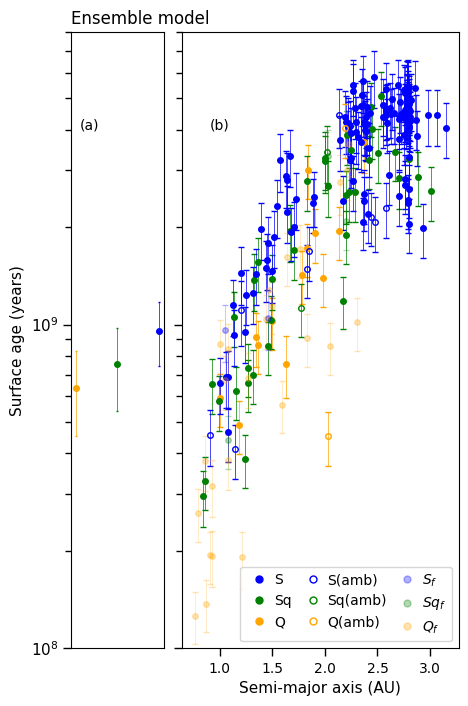

In [ ]:

# Initialize lists to store values for the plot
means_bus_En = []
STD_En_bus = []
means_bus_GP = []
STD_GP_bus = []

labels = []
colors = []
colors1 = []

type = merged_df['Type_bus']

# Create a GridSpec with 1 rows and 4 columns
fig = plt.figure(figsize=(5, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

for i, t in enumerate(selected_types1):
    average_En_bus = np.mean(merged_df['Mean_L'][type == t])
    std_En_bus = np.std(merged_df['Mean_L'][type == t])
    means_bus_En.append(average_En_bus)
    STD_En_bus.append(std_En_bus)

    labels.append(selected_types1[i])

    # Append the corresponding color based on the type (Q, Sq, S)
    colors.append(color_tax[selected_types2[i]])

for i in range(len(selected_types1)):

    ax1.errorbar(
        i, means_bus_En[i], yerr=STD_En_bus[i], capsize=1, fmt='o', linewidth=0.5,
        markersize=4, label=t, color=colors[i]
    )


# Draw a line connecting the mean values for i=0, i=2, and i=3

x_indices = [0, 1, 2]  # Indices you want to connect

y_means_En_bus = [means_bus_En[i] for i in x_indices]
y_means_En_bus_upper = [[means_bus_En[i]+ STD_En_bus[i]] for i in x_indices]
y_means_En_bus_lower = [[means_bus_En[i]- STD_En_bus[i]] for i in x_indices]# Get the mean values at these indices

for t in selected_types2:
    # Check if the type should have an empty marker
    markerfacecolor = 'none' if t in empty_marker_types else color_tax[t]
    fmt = '^' if t in fresh else 'o'
    alpha = 0.3 if t in fresh else 1.0

    ax2.errorbar(merged_df['AU'][type == t], L_corrected[type == t], yerr= L_std_corrected[type == t],
                 capsize=2, fmt='o', linewidth=0.5, markersize=4, label=t, color=color_tax[t],
                 markerfacecolor=markerfacecolor, alpha=alpha)

# Color-coded entries for different types
    line_S = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=5, label='S')
    line_Q = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=5, label='Q')
    line_Sq = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='Sq')
    line_Sno = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=5, label='S(amb)',markerfacecolor = 'none')
    line_Qno = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=5, label='Q(amb)', markerfacecolor = 'none')
    line_Sqno = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='Sq(amb)', markerfacecolor = 'none')
    line_Sf = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=5, label='$S_f$', alpha=alpha)
    line_Sqf = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='$Sq_f$', alpha=alpha)
    line_Qf = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=5, label='$Q_f$', alpha=alpha)

font_size_axis = 11
font_size_markers = 11

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_ylim(10**8, 8*10**9)
ax2.set_ylim(10**8, 8*10**9)
ax1.set_title('Ensemble model', loc='left')
ax1.set_ylabel('Surface age (years)', fontsize=font_size_axis)
ax2.set_xlabel('Semi-major axis (AU)', fontsize=font_size_axis)
ax1.tick_params(axis='y', which='major', length=6, width=1, labelsize=font_size_markers,labelleft=True)
ax1.tick_params(axis='y', which='minor', length=4, width=1, labelsize=font_size_markers,labelleft=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, length=6, width=1)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, length=6, width=1)
ax2.tick_params(axis='y', which='major', length=6, width=1, labelsize=font_size_markers,labelleft=False)
ax2.tick_params(axis='y', which='minor', length=4, width=1, labelsize=font_size_markers)
ax1.text(0.1, 4*10**9,'(a)', fontsize=10, ha='left')
ax2.text(0.9, 4*10**9,'(b)', fontsize=10, ha='left')
ax2.legend(handles=[line_S, line_Sq, line_Q, line_Sno,line_Sqno,line_Qno, line_Sf, line_Sqf, line_Qf],loc='lower right',
           frameon=True, fontsize=10, ncol=3, columnspacing=0.5, handletextpad=0.05)
# Adjust the space between plots
plt.subplots_adjust(hspace=0.2, wspace=0.1)

# Save the plot as png
savefig_kwargs = {"bbox_inches": "tight",
                  "pad_inches": 0.05,
                  "dpi": 100}  # dpi only for jpg/png figures
fig.savefig('StoQ_buss_vert_con.png', format='png', **savefig_kwargs)

plt.show()
from sklearn.linear_model import HuberRegressor

Plot semi-major axis vs. surface age for H ion irradiation

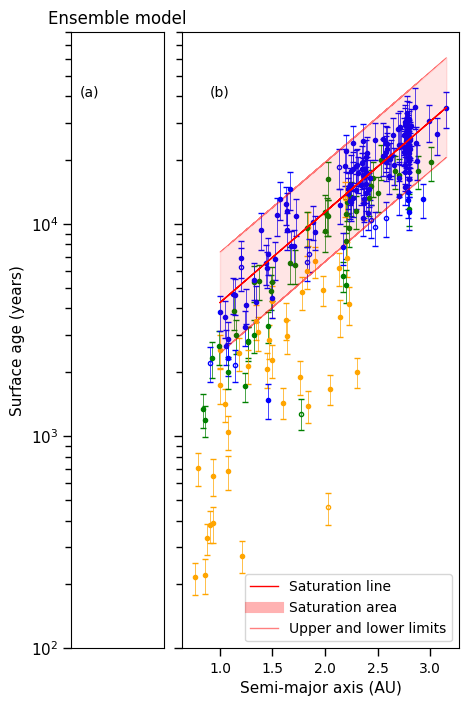

In [ ]:
# ---- Robust Regression (Huber) ----
# Filter data for selected types (e.g., 'Q', 'Sq', 'S')
selected_data_En = []

for l in selected_types3:
    mask = (type == l)
    selected_data_En.append((merged_df['AU'][mask], H_corrected[mask], H_std_corrected[mask]))

# Prepare the data
x_data_En = np.concatenate([d[0] for d in selected_data_En])
y_data_En = np.concatenate([d[1] for d in selected_data_En])
y_err_En = np.concatenate([d[2] for d in selected_data_En])

# Reshape x_data for sklearn
x_data_reshaped_En = x_data_En.reshape(-1, 1)
# Fit Huber robust regression
huber_En = HuberRegressor()
huber_En.fit(x_data_reshaped_En, np.log(y_data_En))

# Predict log-transformed values
log_y_pred_En = huber_En.predict(x_data_reshaped_En)
y_pred_En = np.exp(log_y_pred_En)  # Back-transform to original scale

# Residual standard deviation (SE of residuals)
residuals_En = np.log(y_data_En) - log_y_pred_En
SE_residuals_En = np.std(residuals_En, ddof=1)

# Degrees of freedom and critical t-value for 95% CI
n_En = len(x_data_En)
t_value_En = t.ppf(0.975, df=n_En-2)

# Standard Error of Prediction
x_mean_En = np.mean(x_data_En)
SE_prediction_En = SE_residuals_En * np.sqrt(
    1 + 1/n_En + ((x_data_En - x_mean_En)**2 / np.sum((x_data_En - x_mean_En)**2))
)

# Upper and lower bounds (in log space)
log_y_upper_En = log_y_pred_En + t_value_En * SE_prediction_En
log_y_lower_En = log_y_pred_En - t_value_En * SE_prediction_En

# Back-transform to original scale
y_upper_En = np.exp(log_y_upper_En)
y_lower_En = np.exp(log_y_lower_En)


# Create a GridSpec with 1 rows and 4 columns
fig = plt.figure(figsize=(5, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])

ax40 = fig.add_subplot(gs[0, 0])
ax41 = fig.add_subplot(gs[0, 1])

for i, l in enumerate(selected_types1):
    average_En_bus = np.mean(merged_df['Mean_H'][type == l])
    std_En_bus = np.std(merged_df['Mean_H'][type == l])
    means_bus_En.append(average_En_bus)
    STD_En_bus.append(std_En_bus)

    labels.append(selected_types1[i])

    # Append the corresponding color based on the type (Q, Sq, S)
    colors.append(color_tax[selected_types2[i]])
for i in range(len(selected_types1)):

    ax40.errorbar(i, means_bus_En[i], yerr=STD_En_bus[i], capsize=1, fmt='o', linewidth=0.5,
                     markersize=4, label=t, color=colors[i])

for l in selected_types2:
    # Check if the type should have an empty marker
    markerfacecolor = 'none' if l in empty_marker_types else color_tax[l]

    ax41.errorbar(merged_df['AU'][type == l], H_corrected[type == l], yerr= H_std_corrected[type == l],
                 capsize=2, fmt='o', linewidth=0.5, markersize=3, label=t, color=color_tax[l],
                 markerfacecolor=markerfacecolor)

# Color-coded entries for different types
    line_S = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=5, label='S')
    line_Q = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=5, label='Q')
    line_Sq = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='Sq')
    line_Sno = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=5, label='S(amb)',markerfacecolor = 'none')
    line_Qno = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=5, label='Q(amb)', markerfacecolor = 'none')
    line_Sqno = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='Sq(amb)', markerfacecolor = 'none')

ax41.plot(x_data_En, y_pred_En, color='red', linestyle='-', label="Saturation line", zorder=3, linewidth=1)
sline = mlines.Line2D([], [], color='red', marker='None', linestyle='-', label='Saturation line', linewidth=1)
area = mlines.Line2D([], [], color='red', marker='None', linestyle='-', label='Saturation area', linewidth=8, alpha=0.3)
limits = mlines.Line2D([], [], color='red', marker='None', linestyle='-', label='Upper and lower limits', linewidth=1, alpha=0.5)
ax41.plot(x_data_En, y_upper_En,'r-', linewidth=0.5, alpha=0.5)
ax41.plot(x_data_En, y_lower_En,'r-', linewidth=0.5, alpha=0.5)

# Create finer x_data for better coverage
x_fine_En = np.linspace(x_data_En.min(), x_data_En.max(), 1000)

# Interpolate boundaries
interp_lower_En = interp1d(x_data_En, y_lower_En, kind='linear', fill_value="extrapolate")
interp_upper_En = interp1d(x_data_En, y_upper_En, kind='linear', fill_value="extrapolate")

y_lower_fine_En = interp_lower_En(x_fine_En)
y_upper_fine_En = interp_upper_En(x_fine_En)
ax41.fill_between(x_fine_En, y_lower_fine_En, y_upper_fine_En, color='red', alpha=0.1, label="Saturated area", zorder=4)

font_size_axis = 11
font_size_markers = 11

ax40.set_yscale('log')
ax41.set_yscale('log')

ax40.set_ylim(100, 8*10**4)
ax41.set_ylim(100, 8*10**4)

ax40.set_title('Ensemble model')
ax40.set_ylabel('Surface age (years)', fontsize=font_size_axis)
ax41.set_xlabel('Semi-major axis (AU)', fontsize=font_size_axis)
ax40.tick_params(axis='y', which='major', length=6, width=1, labelsize=font_size_markers,labelleft=True)
ax40.tick_params(axis='y', which='minor', length=4, width=1, labelsize=font_size_markers,labelleft=False)
ax40.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, length=6, width=1)
ax41.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, length=6, width=1)
ax41.tick_params(axis='y', which='major', length=6, width=1, labelsize=font_size_markers,labelleft=False)
ax41.tick_params(axis='y', which='minor', length=4, width=1, labelsize=font_size_markers)
ax40.text(0.1, 4*10**4,'(a)', fontsize=10, ha='left')
ax41.text(0.9, 4*10**4,'(b)', fontsize=10, ha='left')
ax41.legend(handles=[sline, area, limits],loc='lower right', frameon=True, fontsize=10)
# Adjust the space between plots
plt.subplots_adjust(hspace=0.05, wspace=0.1)

# Save the plot as png
savefig_kwargs = {"bbox_inches": "tight",
                  "pad_inches": 0.05,
                  "dpi": 100}  # dpi only for jpg/png figures
fig.savefig('StoQ_H_trend_regression_hori.png', format='png', **savefig_kwargs)

plt.show()